In [17]:
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm.auto import tqdm
from IPython.display import display

import plotly.graph_objects as go
import plotly.express as px

,FundPercentage,FundAmount,FundGoalAmount,TotalFunder,AmountPerFunder
count,55.000000,5.500000e+01,5.500000e+01,55.000000,55.000000
mean,8917.254545,6.193406e+07,1.012727e+06,795.036364,74571.302295
std,13910.514621,8.526203e+07,1.466168e+06,733.715026,61910.327998
min,1283.000000,6.419001e+06,5.000000e+05,67.000000,9261.422638
25%,1731.500000,1.177650e+07,5.000000e+05,241.500000,33997.868713
50%,2583.000000,2.324190e+07,5.000000e+05,574.000000,56874.885845
75%,8579.000000,5.938790e+07,1.000000e+06,985.500000,99537.677643
max,66619.000000,3.330980e+08,1.000000e+07,3006.000000,338522.455090


<AxesSubplot:>

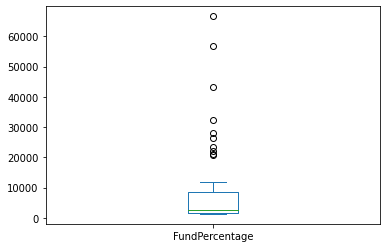

In [18]:
wadiz_list = pd.read_csv("./data/wadiz_list_full.csv", index_col=0)
wadiz_list = wadiz_list[wadiz_list["RemainingDay"] == "종료"]
wadiz_list["FundPercentage"] = wadiz_list["FundPercentage"].apply(lambda x: int(x.replace("%", ""))) # % 제거
wadiz_list["FundAmount"] = wadiz_list["FundAmount"].apply(lambda x: x.replace("원", "")) # 원 제거
wadiz_list["FundAmount"] = wadiz_list["FundAmount"].apply(lambda x: int(x.replace(",", ""))) # , 제거
wadiz_list["FundGoalAmount"] = wadiz_list["FundGoalAmount"].apply(lambda x: x.replace("원", "")) # 원 제거
wadiz_list["FundGoalAmount"] = wadiz_list["FundGoalAmount"].apply(lambda x: int(x.replace(",", ""))) # , 제거
wadiz_list["TotalFunder"] = wadiz_list["TotalFunder"].apply(lambda x: int(x.replace(",", "")))
wadiz_list["AmountPerFunder"] = wadiz_list["FundAmount"] / wadiz_list["TotalFunder"]
wadiz_list.drop("FundPeriod", axis=1, inplace = True)


wadiz_list_group = wadiz_list.groupby(by=["Category"]).mean().sort_values(by=["FundPercentage"], ascending=False)
category_sorter = list(wadiz_list_group.index)
category_sorter_index = dict(zip(category_sorter, range(len(category_sorter))))
wadiz_list_group = wadiz_list_group.reset_index()

# 그룹 순서에 맞게 정렬
wadiz_list["CategoryRank"] = wadiz_list["Category"].map(category_sorter_index)
wadiz_list.sort_values(["CategoryRank"], ascending=True, inplace=True)
wadiz_list.drop("CategoryRank", axis=1, inplace = True)

display(wadiz_list[wadiz_list["Category"] == "출판"].describe())
wadiz_list.loc[wadiz_list["Category"] == "출판", "FundPercentage"].plot(kind="box")

* 출판 분야의 프로젝트 수가 55개로 적은 반면에, 표준편차가 크고 평균이 8917, 중앙값이 2583으로 소수의 매우 큰 값들이 평균에 큰 영향을 주고 있는 것을 확인하였다.
* 따라서 75%인 8579까지만 반영하여 다시 평균 차트를 그려보았다.

In [34]:
df_group = wadiz_list[
    ((wadiz_list["Category"] == "출판") & (wadiz_list["FundPercentage"] <= 8579))
    | (wadiz_list["Category"] != "출판")
].groupby(by=["Category"]).mean().reindex(category_sorter).reset_index()

fig = px.bar(
    df_group, x="Category", y="FundPercentage", color="Category", title="펀딩 달성률 평균"
)
fig.update_layout(showlegend=False, yaxis_title="펀딩 달성률 (%)")
fig.show()


/Users/CUop/opt/anaconda3/envs/jupy/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning:

urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!



출판 분야만 차별한 것 같다... 다른 분야들도 75%까지 필터링 해보자!

In [52]:
df = wadiz_list
for cate in category_sorter:
    df = df[
        ((df["Category"] == cate) & (df["FundPercentage"] <= df[df["Category"] == cate].quantile(0.75)["FundPercentage"]))
        | (df["Category"] != cate)
    ]
df["Count"] = 1
display(df.describe())

df_sum = df.groupby(by=["Category"]).sum()
dict_category_count = dict(zip(df_sum.index, df_sum["Count"]))

df = df.groupby(by=["Category"]).mean().reindex(category_sorter).reset_index()
fig = px.bar(
    df, x="Category", y="FundPercentage", color="Category", title="펀딩 달성률 평균"
)
fig.update_layout(showlegend=False, yaxis_title="펀딩 달성률 (%)")
fig.show()

,FundPercentage,FundAmount,FundGoalAmount,TotalFunder,AmountPerFunder,Count
count,7041.000000,7.041000e+03,7.041000e+03,7041.000000,7.041000e+03,7041.0
mean,2472.517256,2.723314e+07,1.105667e+06,372.393268,1.049383e+05,1.0
std,1022.290301,4.958118e+07,2.161652e+06,452.113178,1.539123e+05,0.0
min,216.000000,1.080120e+06,3.000000e+05,7.000000,9.042693e+03,1.0
25%,1641.000000,1.103470e+07,5.000000e+05,147.000000,4.333031e+04,1.0
50%,2187.000000,1.657700e+07,1.000000e+06,251.000000,6.563143e+04,1.0
75%,3065.000000,2.729690e+07,1.000000e+06,443.000000,1.134959e+05,1.0
max,8147.000000,1.839845e+09,1.000000e+08,10740.000000,6.862955e+06,1.0


이제 유의미한 차이가 없다.

&(7.14) https://blog.revolutionanalytics.com/2017/05/the-datasaurus-dozen.html
* 조그만 차이에도 상관관계 등이 매우 큰 차이를 보인다면, 부주의한 데이터 분석은 완전히 잘못된 결과를 보여줄 수 있다.
* 그렇다면, 다른 사람의 데이터 분석을 어떻게 검증하고 신뢰할 수 있을까?

&(7.14) 다양한 데이터 분석 시도가 필요하다면, 그 중 무엇을 어떻게 선택하는가?

In [58]:
df["Count"] = df["Category"].map(dict_category_count)

fig = px.scatter(df, x="FundPercentage", y="FundAmount", color="Category", size="Count")
fig.show()

fig = px.scatter_3d(df, x="FundPercentage", y="FundAmount", z="Count", color="Category")
fig.show()

3d scatter 보다 sized 2d scatter가 더 보기 쉽고 직관적이다.